In [2]:
#import ....
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Begin answering questions. Please start a new cell for each question.

In [71]:
# Q1.1
# Naive data linkage without blocking

# Installing the textdistance library
# !conda install -c conda-forge textdistance (in terminal)

import textdistance

# Loading CSV into a pandas data frame
df_1 = pd.read_csv('google_small.csv', encoding='ISO-8859-1')
df_2 = pd.read_csv('amazon_small.csv', encoding='ISO-8859-1')

### 1. Detecting duplication

df_duplicated_google = df_1[df_1.duplicated()]
df_duplicated_amazon = df_2[df_2.duplicated()]

df_small_google = df_1
df_small_amazon = df_2

### No duplications were found

In [72]:
### Feature engineering 

### Generate new feature with combination of 3 featueres.

# Check for the type.
type(df_small_amazon.description[0])

# Replace missing values (NaN) with empty strings in the Amazon data frame.
df_small_amazon_fix = df_small_amazon.replace(np.nan, '', regex=True)

# Check for and count missing values in the Amazon data frame.
df_small_amazon_fix.isnull().sum()

# Create a new feature in the Amazon data frame by combining the 'title,' 'description,' and 'manufacturer' columns.
df_small_amazon_fix['combined_feature'] = df_small_amazon_fix.title + df_small_amazon_fix.description + df_small_amazon_fix.manufacturer

# Replace missing values (NaN) with empty strings in the Google data frame.
df_small_google_fix = df_small_google.replace(np.nan, '', regex=True)

# Check for and count missing values in the Google data frame.
df_small_google_fix.isnull().sum()

# Create a new feature in the Google data frame by combining the 'name,' 'description,' and 'manufacturer' columns.
df_small_google_fix['combined_feature'] = df_small_google_fix.name + df_small_google_fix.description + df_small_google_fix.manufacturer


In [73]:

### Using the similarity score on the newly engineered features and price

## Cosine similarity function 
import re, math
from collections import Counter

WORD = re.compile(r'\w+')

def get_cosine(vec1, vec2):
     intersection = set(vec1.keys()) & set(vec2.keys())
     numerator = sum([vec1[x] * vec2[x] for x in intersection])

     sum1 = sum([vec1[x]**2 for x in vec1.keys()])
     sum2 = sum([vec2[x]**2 for x in vec2.keys()])
     denominator = math.sqrt(sum1) * math.sqrt(sum2)

     if not denominator:
        return 0.0
     else:
        return float(numerator) / denominator

def text_to_vector(text):
     words = WORD.findall(text)
     return Counter(words)

In [74]:
# Create a list to store matched items by title or name.
matched_list = pd.DataFrame()

# Layer 1 - string match with title VS name
for i in range(1, len(df_small_amazon.title)):
    similar_score = []
    matched_amazon_combined = []
    matched_google_combined = []

    # Create columns to hold the similar price for the further layer
    matched_amazon_title = []
    matched_google_title = []

    matched_amazon_price = []
    matched_google_price = []

    matched_amazon_id = []
    matched_google_id = []

    for j in range(1, len(df_small_google.name)):
        vector1 = text_to_vector(df_small_amazon_fix.title[i])
        vector2 = text_to_vector(df_small_google_fix.name[j])

        similar_combined = get_cosine(vector1, vector2)

        # Append similarity scores and other attributes to lists
        similar_score.append(similar_combined)
        matched_amazon_combined.append(df_small_amazon_fix.combined_feature[i])
        matched_google_combined.append(df_small_google_fix.combined_feature[j])
        matched_amazon_title.append(df_small_amazon_fix.title[i])
        matched_google_title.append(df_small_google_fix.name[j])
        matched_google_id.append(df_small_google.idGoogleBase[j])
        matched_amazon_id.append(df_small_amazon.idAmazon[i])

        # Adding price attributes to matched titles dataframe
        matched_amazon_price.append(df_small_amazon.price[i])
        matched_google_price.append(df_small_google.price[j])

    # Combine lists into a DataFrame
    zippedList = list(zip(
        matched_amazon_id,
        matched_google_id,
        similar_score,
        matched_amazon_title,
        matched_google_title,
        matched_amazon_price,
        matched_google_price
    ))

    all_match_score = pd.DataFrame(zippedList, columns=[
        'matched_amazon_id',
        'matched_google_id',
        'similarity_score',
        'matched_amazon_combined',
        'matched_google_combined',
        'matched_amazon_price',
        'matched_google_price'
    ])

    sorted_data = all_match_score.sort_values('similarity_score')

    # Find the max similarity for each item in the first list
    top_match = sorted_data[-1:]

    # Attach the matches with the max similarity to the main matched_list
    matched_list = pd.concat([matched_list, top_match])

# Sort the matched_list by similarity score in descending order
sorted_match = matched_list.sort_values('similarity_score', ascending=False)

In [132]:
# loading the truth small csv 

true_match_df = pd.read_csv('amazon_google_truth_small.csv', encoding = 'ISO-8859-1')



true_match = ( true_match_df['idAmazon'] + true_match_df['idGoogleBase']).tolist()


# thresholds list to find optimal performance

thresholds = [ 0.1, 0.2, 0.3 , 0.31, 0.32, 0.33, 0.34, 0.35, 0.36 , 0.38 ,0.4 , 0.5 , 0.6, 0.7, 0.8, 0.9, 1 ]

for s in thresholds :

    predict_match_full = sorted_match.loc[sorted_match['similarity_score'] >= s]

    predict_match = ( predict_match_full['matched_amazon_id'] + predict_match_full['matched_google_id']).tolist()




    TP = 0
    TN = 0
    FP = 0 
    FN = 0 

    for i in range(0, len(predict_match)):
        for j in range(0,len(true_match)):
            if predict_match[i] == true_match[j]:
                TP += 1
 
    
    FN = (len(true_match)) - TP
    
    FP = len(predict_match) - TP


    TN = len(predict_match)*len(true_match) - TP - FP - FN 

    accuracy = (TP + TN)/ (TP + FP + FN + TN )

    precision = TP / (TP + FP) 

    recall = TP / (TP + FN) 

    print('Now thresholds is :' , s)
    print('length of predict match is :' , len(predict_match))
    print('TP :' ,TP  )
    print('FP :' ,FP  )
    print('FN :' ,FN  )
    print('TN :' ,TN  )
    print('')
    print('Accuracy is :' , accuracy)
    print('precision is :', precision)
    print('recall is :', recall)

    print('============================================')

Now thresholds is : 0.1
length of predict match is : 145
TP : 121
FP : 24
FN : 9
TN : 18696

Accuracy is : 0.9982493368700265
precision is : 0.8344827586206897
recall is : 0.9307692307692308
Now thresholds is : 0.2
length of predict match is : 144
TP : 121
FP : 23
FN : 9
TN : 18567

Accuracy is : 0.9982905982905983
precision is : 0.8402777777777778
recall is : 0.9307692307692308
Now thresholds is : 0.3
length of predict match is : 141
TP : 121
FP : 20
FN : 9
TN : 18180

Accuracy is : 0.998417894162575
precision is : 0.8581560283687943
recall is : 0.9307692307692308
Now thresholds is : 0.31
length of predict match is : 141
TP : 121
FP : 20
FN : 9
TN : 18180

Accuracy is : 0.998417894162575
precision is : 0.8581560283687943
recall is : 0.9307692307692308
Now thresholds is : 0.32
length of predict match is : 140
TP : 121
FP : 19
FN : 9
TN : 18051

Accuracy is : 0.9984615384615385
precision is : 0.8642857142857143
recall is : 0.9307692307692308
Now thresholds is : 0.33
length of predict ma

In [130]:
148+130 -121 -19-9

128

###  Q. Comments  on the linkage method and its performance. Comments should include the choices of similarity functions and final scoring function and threshold and also include comments on overall performance of your method.

###  A. My linkage method is find similarity base on the amazone and google. title, applied the cosine similarity function.  use the each best mached title from both datasets to compare with the true sets with a threshold is 0.33 on cosine similarity score is optimal to get Accuracy is : 0.896    precision is : 0.86     recall is : 0.93. 

### The cosines similarity function performs better than the editing base and sequence base string similarity funciton .

### The overall performance base on only title is pretty good.  it could be improved by apply cosine similarty to measure description by removing the insignificnat words in the string . And also the price range elimination the False Positive would be another layer of filter may increase the perfomance.




### ================================================================
## Blocking for effcient data linkage

In [301]:
###Blocking for effcient data linkage

## impute google manufacturers by other column 

df_google = pd.read_csv('google.csv', encoding = 'ISO-8859-1')
df_amazon = pd.read_csv('amazon.csv', encoding = 'ISO-8859-1')


df_amazon = df_amazon.replace(np.nan, '', regex=True)
df_google = df_google.replace(np.nan, '', regex=True)


### extracting some features from name and description for matching 


amazon_name_extract = [] 
amazon_des_extract = []


for i in range(0,len(df_amazon)):
    
    str = df_amazon['title'][i]
    amazon_des_extract.append([int(s) for s in str.split() if s.isdigit()])
    


### first bolcking by price  
## 5 blocks | 0 | >$0 - $25| $>25 -$45 | $45 - $135|  > $135 | base on the spead of price data. 

df_amazon_block_1 = df_amazon[(df_amazon['price'] == 0) & (df_amazon['price'] == None)& (df_amazon['price'] == np.nan)] 
df_amazon_block_2 = df_amazon[(df_amazon['price'] > 0) & (df_amazon['price'] <=25)]
df_amazon_block_3 = df_amazon[(df_amazon['price'] > 25) & (df_amazon['price'] <=45)]
df_amazon_block_4 = df_amazon[(df_amazon['price'] > 45) & (df_amazon['price'] <=135)]
df_amazon_block_5 = df_amazon[(df_amazon['price'] > 135)]

## f_amazon_block_1 is empty so 4 Blocks left 




## removing the unit and convert to string
df_google['price'] = df_google['price'].map(lambda x: x.rstrip(' gbp'))

df_google['price'] = pd.to_numeric(df_google['price'])


df_google_block_1 = df_google[(df_google['price'] == 0) & (df_google['price'] == None)& (df_google['price'] == np.nan)] 
df_google_block_2 = df_google[(df_google['price'] > 0) & (df_google['price'] <= 25)]
df_google_block_3 = df_google[(df_google['price'] > 25) & (df_google['price'] <=45)]
df_google_block_4 = df_google[(df_google['price'] > 45) & (df_google['price'] <=135)]
df_google_block_5 = df_google[(df_google['price'] > 135)]






In [315]:
block2_matching = []
df_amazon_block_2 = df_amazon_block_2.reset_index()
df_google_block_2 = df_google_block_2.reset_index()

for i in range(0,len(df_amazon_block_2)):
    for j in range(0,len(df_google_block_2)):
        block2_matching.append((df_amazon_block_2['idAmazon'][i] + df_google_block_2['id'][j]))




In [323]:
block3_matching = []
df_amazon_block_3 = df_amazon_block_3.reset_index()
df_google_block_3 = df_google_block_3.reset_index()

for i in range(0,len(df_amazon_block_3)):
    for j in range(0,len(df_google_block_3)):
        block3_matching.append((df_amazon_block_3['idAmazon'][i] + df_google_block_3['id'][j]))



In [324]:
block4_matching = []
df_amazon_block_4 = df_amazon_block_4.reset_index()
df_google_block_4 = df_google_block_4.reset_index()

for i in range(0,len(df_amazon_block_4)):
    for j in range(0,len(df_google_block_4)):
        block4_matching.append((df_amazon_block_4['idAmazon'][i] + df_google_block_4['id'][j]))

In [325]:
block5_matching = []
#df_amazon_block_5 = df_amazon_block_5.reset_index()
#df_google_block_5 = df_google_block_5.reset_index()

for i in range(0,len(df_amazon_block_5)):
    for j in range(0,len(df_google_block_5)):
        block5_matching.append((df_amazon_block_5['idAmazon'][i] + df_google_block_5['id'][j]))

In [337]:
block_predict_match = block2_matching + block3_matching + block4_matching + block5_matching

In [335]:
block_predict_list[2987]

'b0000ycfcwhttp://www.google.com/base/feeds/snippets/9558419339728905800'

In [332]:
### extract number from features
str = df_amazon['title'][0]
[int(s) for s in str.split() if s.isdigit()]


[950, 0]

In [144]:
### extract string from name  and  decription 
str = "learning quickbooks 2007"
[int(s) for s in str.split() if s.isdigit()]



[2007]

In [338]:
### loading the ground truth data

ground_true_match_df = pd.read_csv('amazon_google_truth.csv', encoding = 'ISO-8859-1')


### for two id become a string
ground_true_match = (ground_true_match_df['idAmazon'] + ground_true_match_df['idGoogleBase']).tolist()



##  initial the counting for result
tp = 0
tn = 0
fp = 0 
fn = 0 

for i in range(0, len(block_predict_match)):
    for j in range(0,len(ground_true_match)):
        if block_predict_match[i] == ground_true_match[j]:
            tp += 1
 
 

In [345]:
   
fn = (len(ground_true_match)) - tp
    
fp = len(block_predict_match) - tp


tn = len(block_predict_match)*len(ground_true_match) - tp - fp - fn 

n = len(block_predict_match)*len(ground_true_match)
    
PC = tp/(tp + fn)
RR = 1- ((tp + fp)/n)


print('length of predict match is :' , len(predict_match))
print('TP :' ,tp  )
print('FR :' ,fp  )
print('FN :' ,fn  )
print('TN :' ,tn  )
print('')
print('Pair completeness PC is :' , PC)
print('Reduction ratio RR is :', RR)

print('============================================')

length of predict match is : 3
TP : 982
FR : 962696
FN : 318
TN : 1251817404

Pair completeness PC is : 0.7553846153846154
Reduction ratio RR is : 0.9992307692307693


### Comments

### Q . The discussion on the blocking method and its quality. ## Comments should include the choices of blocking method and how the method relates to the two quality measures

## choices of blocking method
###  first bolcking by price  5 blocks  | 0 |  >0 - 25| >25 -45 | 45 - 135|  > 135 | base on the spead of price data qualtles and median on both amazon and google datasets. 

### second stage  re-organising the elements in block by extract string from name and decription if 



## methods relates to the two quality measures

### the blocking methods are blocking by price in to 4 blocks for each datasets. it reduce the computational time for data linkage

### Pair completeness PC is : 0.7553846153846154
### Reduction ratio RR is : 0.9992307692307693

### Pair completeness (PC) = tp/(tp + fn)
### What proportion of actual positives matches was identified correctly TP increase , the Pair completness expecting to increase if the blocking method is performaing good.  


###  Reduction ratio (RR) = 1 - (tp + fp)/n

###   how the blocking method performed,  high RR offers high efficency for record linkage between datasets


### ==============================================================

## Part 2 Classfication 

,mcg,gvh,alm,mit,vac,erl,pox,nuc
1416,0.42,0.71,0.45,0.15,0.48,0.5,0.00,0.22
667,0.56,0.63,0.52,0.20,0.34,0.5,0.00,0.26
734,0.51,0.46,0.57,0.25,0.53,0.5,0.00,0.22
1042,0.52,0.54,0.47,0.49,0.54,0.5,0.00,0.22
764,0.45,0.41,0.49,0.14,0.53,1.0,0.00,0.30
200,0.57,0.57,0.44,0.37,0.52,0.5,0.00,0.25
1060,0.56,0.49,0.32,0.22,0.50,0.5,0.00,0.22
185,0.31,0.55,0.52,0.17,0.52,0.5,0.00,0.22
1170,0.56,0.52,0.46,0.17,0.49,0.5,0.00,0.73
715,0.48,0.49,0.45,0.23,0.51,0.5,0.00,0.22


In [3]:
### part 2 Classification 

### Pre-processing

# impute the missing data by mean and median, and than make comparision

df1 = pd.read_csv('all_yeast.csv',encoding = 'ISO-8859-1')

df2 = pd.read_csv('all_yeast.csv',encoding = 'ISO-8859-1')


# removing the sample id 

df_selected_1 = df1.loc[:, df1.columns != 'Sample']
df_selected_2 = df2.loc[:, df2.columns != 'Sample']

In [83]:
print (df1['erl'].value_counts())

0.500000    1430
1.000000      14
3.500849       1
Name: erl, dtype: int64


In [84]:
df1['pox'].value_counts()

0.00    1469
0.83      11
0.50       4
Name: pox, dtype: int64

In [5]:
# removing the data 'erl' and 'pox' and imputing these two column by 0.5 and 0 --by majority. 
# since as we print the data these columns are not suits for imputes by mean or median.
# and They are ambigusily to saying it is discrete data or continous. since there are rare continous values appears
# in this case I treat them as continoius, since we need to stadarlise and mean center transformation data later 
# These to col could be invovled in the transformation if treated as contious data.


col_erl = df_selected_1.erl
col_pox = df_selected_2.pox

df_selected_1 = df_selected_1.drop(['erl','pox'], axis=1)
df_selected_2 = df_selected_2.drop(['erl','pox'], axis=1)

# Display description of yeast medata

# fill missing value by mean 
df_selected_1.fillna(df_selected_1.mean(),inplace=True)

# fill missing value by median 
df_selected_2.fillna(df_selected_2.median(),inplace=True)

col_erl.fillna(0.5,inplace=True)
col_pox.fillna(0,inplace=True)

# put data colums back together after imputation 
# make copy with original data for reference or later use. 
df_selected_1_cpy = df_selected_1
df_selected_2_cpy = df_selected_1


df_selected_1.insert(5, 'erl', col_erl)
df_selected_1.insert(6, 'pox', col_pox)

df_selected_2.insert(5, 'erl', col_erl)
df_selected_2.insert(6, 'pox', col_pox)

print(df_selected_1.describe())
print(df_selected_2.describe())

               mcg          gvh          alm          mit          vac  \
count  1484.000000  1484.000000  1484.000000  1484.000000  1484.000000   
mean      0.499349     0.499876     0.505848     0.264379     0.503816   
std       0.131357     0.121945     0.199837     0.150286     0.153481   
min       0.110000     0.130000     0.210000     0.000000     0.000000   
25%       0.410000     0.420000     0.460000     0.170000     0.480000   
50%       0.499349     0.490000     0.510000     0.230000     0.510000   
75%       0.562500     0.570000     0.550000     0.300000     0.530000   
max       1.000000     1.000000     7.501819     3.000728     6.001456   

               erl          pox          nuc  
count  1484.000000  1484.000000  1484.000000  
mean      0.506739     0.007500     0.279816  
std       0.091580     0.075683     0.151736  
min       0.500000     0.000000     0.000000  
25%       0.500000     0.000000     0.220000  
50%       0.500000     0.000000     0.220000  
75% 

### Q.preprocessing data --- Comparision with replacement by mean vs repalcement by median

### A. From the boxplot below we could see the values from each column are skewed and not spread evenly, using median is a better choice by compairing with  mean to impute data, since the mean may creates much bigger bias in values not spread evenly. removing the data 'erl' and 'pox' and imputing these two column by 0.5 and 0 which are based on majority. This appoach is better than the mean and median. since the probability to get non_majory value is very low whihc indicates that getting the mean and median is low probability. 

### Removing columns 'erl' and 'pox' and imputing these two column by 0.5 and 0 --by majority. 
### since these columns are not suits for imputes by mean or median.
### and They are ambigusily to say that it is discrete data or continous. since there are rare continous values appears in both comlumn. 
###  in this case,  I treat them as continoius, since we need to stadarlisation  and mean center transformation data later 
###  These two collumn could be invovled in the transformation if treated as contious data.

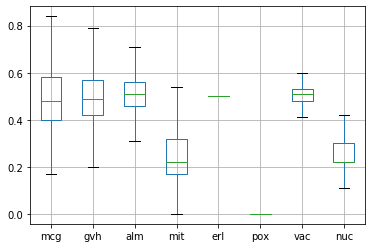

In [6]:
%matplotlib inline

# using the data frame before imputation to plot graph
df_box_plot = pd.read_csv('all_yeast.csv',encoding = 'ISO-8859-1')

# remove the id smaple

df_selected = df_box_plot.loc[:, df_box_plot.columns != 'Sample']

boxplot = df_selected.boxplot(showfliers=False)

### Scale the features:
### Scale features will be applied after split the training and testing dataset  for both Mean centering and standarlisation 

In [500]:
#using data after median imputation ----df_selected_2

from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

# selecting the features coulumns.

df_features = df_selected_2.loc[:, df_selected_2.columns != 'Class']

df_labels = df_selected_2.Class

df_features_selected = df_features.loc[:, df_features.columns != 'Samples']

columns_yeast = ['mcg', 'gvh', 'alm', 'mit', 'erl','pox', 'vac', 'nuc']


### Scaleling is better taken afer spliting the data.

#spliting data and standardlised data 

le = preprocessing.LabelEncoder()
le.fit(df_labels)

y = le.transform(df_labels) 

x = df_features_selected

std_scale_x = preprocessing.StandardScaler().fit(x)

x_df_std = std_scale_x.transform(x)
 
    
# splitting datasets into training and testing 
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.33, random_state = 100)


# mean centering transformation 
mean_center_scale_xTrain= preprocessing.StandardScaler(copy=True, with_mean=True, with_std=False).fit(xTrain)
mean_center_scale_xTest= preprocessing.StandardScaler(copy=True, with_mean=True, with_std=False).fit(xTest)
xTrain_mc = mean_center_scale_xTrain.transform(xTrain)
xTest_mc = mean_center_scale_xTest.transform(xTest)
   
mean_data = pd.DataFrame(xTrain_mc, columns = columns_yeast)
print(mean_data.describe())
                                             
                                             

# standalisation transformation ---with Train and test data separately 
std_scale_xTrain = preprocessing.StandardScaler().fit(xTrain)

std_scale_xTest = preprocessing.StandardScaler().fit(xTest)
xTrain_df_std = std_scale_xTrain.transform(xTrain)
xTest_df_std = std_scale_xTest.transform(xTest)

std_data = pd.DataFrame(xTrain_df_std, columns = columns_yeast)

print(std_data.describe())

        

                mcg           gvh           alm           mit           erl  \
count  9.940000e+02  9.940000e+02  9.940000e+02  9.940000e+02  9.940000e+02   
mean   4.462114e-17 -3.384281e-17  7.371702e-18 -7.315856e-18  4.607314e-17   
std    1.348446e-01  1.245401e-01  2.376220e-01  1.595658e-01  1.832468e-01   
min   -3.888934e-01 -3.709155e-01 -2.989556e-01 -2.621939e-01 -5.061483e-01   
25%   -8.889336e-02 -8.091549e-02 -3.895555e-02 -9.219389e-02 -2.614835e-02   
50%   -1.889336e-02 -1.091549e-02  1.044447e-03 -4.219389e-02  3.851654e-03   
75%    6.110664e-02  6.908451e-02  4.104445e-02  4.780611e-02  2.385165e-02   
max    4.711066e-01  4.990845e-01  6.992864e+00  2.738534e+00  5.495307e+00   

                pox           vac           nuc  
count  9.940000e+02  9.940000e+02  9.940000e+02  
mean   1.317971e-17 -2.075036e-17  4.037682e-17  
std    1.084654e-01  7.898233e-02  1.692348e-01  
min   -8.552162e-03 -8.189135e-03 -2.777878e-01  
25%   -8.552162e-03 -8.189135e-03 -5.7

### compare two different scalling methods' effects.                                    
###  Both of mean centering and standardisation have the mean very close to zero 
###  But for stadard Deviation of standardlisation is very close to 1. 

## ===========================================
### Comparing Classification Algorithms 

In [51]:
print(xTrain_df_std.shape)
print(xTest_df_std.shape)

(994, 8)
(490, 8)


In [397]:
# splitting datasets into training and testing 
## special split for Gridsearch to provide information leak
xTrain_90, xTest_90, yTrain_90, yTest_90 = train_test_split(x, y, test_size = 0.1, random_state = 100)


# standalisation transformation ---with 90% grisearch and 10% holdout.
std_scale_xTrain = preprocessing.StandardScaler().fit(xTrain_90)

std_scale_xTest = preprocessing.StandardScaler().fit(xTest_90)
xTrain_90_std = std_scale_xTrain.transform(xTrain_90)
xTest_90_std = std_scale_xTest.transform(xTest_90)




In [614]:
## Comparing the knn(k=5), knn(k=10), Decision tree
#knn(k=5)  with median imputed mean centering data


print('------------mean centering transformation---------------------')


knn5_mc = KNeighborsClassifier(n_neighbors=5)
knn5_mc.fit(xTrain_mc,yTrain)
pred_knn5_mc = knn5_mc.predict(xTest_mc)

print(accuracy_score(yTest,pred_knn5_mc))

#knn(k=10)

knn10_mc = KNeighborsClassifier(n_neighbors=10)
knn10_mc.fit(xTrain_mc,yTrain)
pred_knn10_mc = knn10_mc.predict(xTest_mc)

print(accuracy_score(yTest,pred_knn10_mc))


#Decision Tree
D_tree_mc = DecisionTreeClassifier(random_state=100)
D_tree_mc.fit(xTrain_mc,yTrain)
pred_Dtree_mc = D_tree_mc.predict(xTest_mc)

print(accuracy_score(yTest,pred_Dtree_mc))


## Comparing the knn(k=5), knn(k=10), Decision tree
#knn(k=5)  with median imputed mean centering data

print('------------standalised transformation---------------------')

knn5_std = KNeighborsClassifier(n_neighbors=5)
knn5_std.fit(xTrain_df_std,yTrain)
pred_knn5_std = knn5_std.predict(xTest_df_std)

print(accuracy_score(yTest,pred_knn5_std))

#knn(k=10)

knn10_std = KNeighborsClassifier(n_neighbors=10)
knn10_std.fit(xTrain_df_std,yTrain)
pred_knn10_std = knn10_std.predict(xTest_df_std)

print(accuracy_score(yTest,pred_knn10_std))


#Decision Tree
D_tree_std = DecisionTreeClassifier(random_state=)
D_tree_std.fit(xTrain_df_std,yTrain)
pred_Dtree_std = D_tree_std.predict(xTest_df_std)

print(accuracy_score(yTest,pred_Dtree_std))

------------mean centering transformation---------------------
0.6632653061224489
0.6755102040816326
0.6571428571428571
------------standalised transformation---------------------
0.6959183673469388
0.7040816326530612
0.6653061224489796


In [23]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(yTest,pred_knn5_std)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.6181511795859412

In [487]:
# cross validation for tuning the hyperparameters for KNN. 


from sklearn.model_selection import GridSearchCV

model = KNeighborsClassifier(n_jobs=-1)

scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}


## parameter sets for Knn
params = {'n_neighbors':[2,3,4,5,6,7,8,9,10],
          'leaf_size':[1,2,3,5],
          'weights':['uniform', 'distance'],
          'algorithm':['auto', 'ball_tree','kd_tree','brute'],
          'p':[1,2],
          'n_jobs':[-1]}

gs_knn = GridSearchCV(model,cv=3, param_grid=params,scoring=scoring,refit='AUC',return_train_score=True)


gs_knn.fit(xTrain_90_std,yTrain_90)


print("Best Hyper Parameters:\n",gs_knn.best_params_)

pred_knn = gs_knn.predict(xTest_90_std)

results_knn = gs_knn.cv_results_

from sklearn import metrics
#evaluation(Accuracy)
print("Accuracy:",metrics.accuracy_score(pred_knn,yTest_90))
#evaluation(Confusion Metrix)
print("Confusion Metrix:\n",metrics.confusion_matrix(pred_knn,yTest_90))




Best Hyper Parameters:
 {'algorithm': 'auto', 'leaf_size': 1, 'n_jobs': -1, 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
Accuracy: 0.6845637583892618
Confusion Metrix:
 [[19 18]
 [29 83]]


In [489]:
print(gs_knn.best_params_)
print(gs_knn.best_score_)
print(gs_knn.best_index_)


{'algorithm': 'auto', 'leaf_size': 1, 'n_jobs': -1, 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}
0.7515472523886447
33


In [610]:
#fitting the 66% data from the best parameter estimated from full dataset from gridsearch CV
#Best Hyper Parameters:
# {'algorithm': 'auto', 'leaf_size': 1, 'n_jobs': -1, 'n_neighbors': 6, 'p': 2, 'weights': 'distance'}

knn_full_df = KNeighborsClassifier(n_neighbors=6, algorithm= 'auto', leaf_size=1, n_jobs= -1, p=2,weights= 'distance')
knn_full_df.fit(xTrain_df_std,yTrain)
pred_full_df = knn_full_df.predict(xTest_df_std)

print(accuracy_score(yTest,pred_full_df))

#fitting the 66% data from the best parameters were estimated from 90% data girdsearch
#Best Hyper Parameters:
# {'algorithm': 'auto', 'leaf_size': 1, 'n_jobs': -1, 'n_neighbors': 10, 'p': 1, 'weights': 'distance'}

knn_90_df = KNeighborsClassifier(n_neighbors=10, algorithm= 'auto', leaf_size=1, n_jobs= -1, p=1,weights= 'distance')
knn_90_df.fit(xTrain_df_std,yTrain)
pred_90_df = knn_90_df.predict(xTest_df_std)

print(accuracy_score(yTest,pred_90_df))


## comparision with different hold out and gridsearch pattern

#hold out 10% is better.

0.6857142857142857
0.7


In [492]:
result_knn_df = pd.DataFrame(results_knn)

selected_knn_df = result_knn_df[['params','mean_train_AUC','mean_test_AUC','mean_train_Accuracy', 'mean_test_Accuracy']]

sort_selected_knn_df = selected_knn_df.sort_values('mean_train_AUC',ascending=False)

old_index_string_knn = list(str(x) for x in sort_selected_knn_df.index)

sort_selected_knn_df['old_comb_params_id'] = old_index_string_knn

sort_selected_knn_df = sort_selected_knn_df.reset_index()

index_string_knn = list(str(x) for x in sort_selected_knn_df.index)

In [474]:
sort_selected_knn_df['params'][360]

{'algorithm': 'kd_tree',
 'leaf_size': 1,
 'n_jobs': -1,
 'n_neighbors': 2,
 'p': 1,
 'weights': 'uniform'}

In [486]:
sort_selected_knn_df['params'][309]

{'algorithm': 'auto',
 'leaf_size': 3,
 'n_jobs': -1,
 'n_neighbors': 4,
 'p': 1,
 'weights': 'distance'}

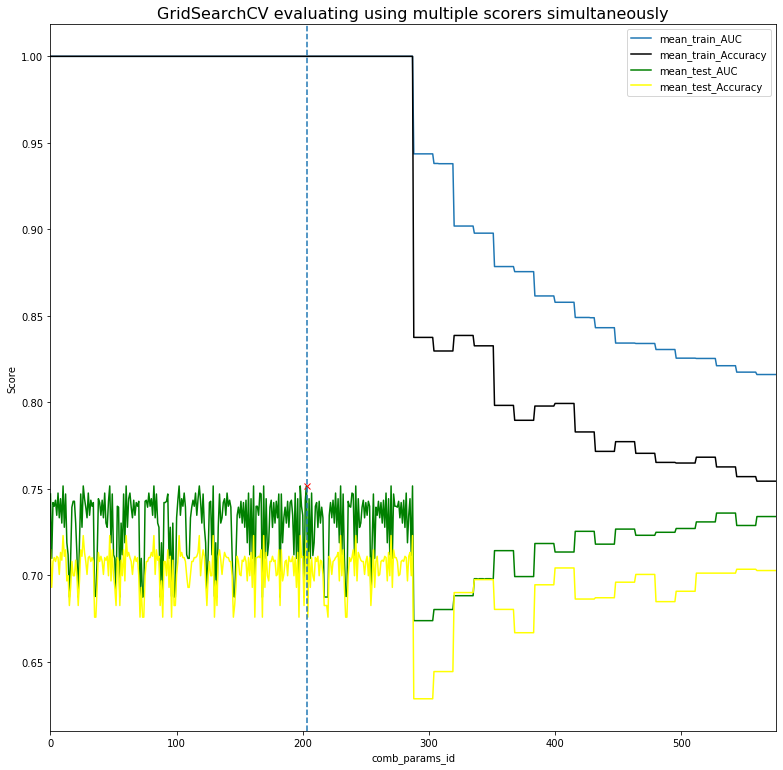

In [495]:
import matplotlib.pyplot as plt
import pandas as pd

## make Id columns 

sort_selected_knn_df['comb_params_id'] = index_string_knn

# gca stands for 'get current axis'
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
          fontsize=16)

plt.xlabel("Comb Params ID")
plt.ylabel("Score")



ax1 = plt.gca()

sort_selected_knn_df.plot(kind='line',x='comb_params_id',y='mean_train_AUC',ax=ax1)
sort_selected_knn_df.plot(kind='line',x='comb_params_id',y='mean_train_Accuracy', color='black', ax=ax1)
sort_selected_knn_df.plot(kind='line',x='comb_params_id',y='mean_test_AUC',color='green', ax=ax1)
sort_selected_knn_df.plot(kind='line',x='comb_params_id',y='mean_test_Accuracy', color='yellow', ax=ax1)


best_index_sort_knn= sort_selected_knn_df[sort_selected_knn_df['old_comb_params_id'] == '33'].index

plt.plot(best_index_sort_knn,gs_knn.best_score_ , 'rx')

plt.axvline(x= best_index_sort_knn, ls = '--')

# Annotate the best score for that scorer
#ax.annotate("%0.2f" % best_score, (best_index, best_score + 0.005))

plt.show()

In [497]:
max_depths

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32.])

In [553]:
#With Hyper Parameters Tuning
#2-1,DesicionTree
#importing modules

import numpy as np
from matplotlib import pyplot as plt

from sklearn.datasets import make_hastie_10_2
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

#making the instance


scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}

model= DecisionTreeClassifier(random_state=10)


#Hyper Parameters Set for DecisionTree
params = {'max_features': ['auto', 'sqrt', 'log2', None ],
          'min_samples_split': [2,3,4,5,6,7,8,9,10,11,12,13,14,15], 
          'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10,11],
          'max_depth':[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,None],
          'random_state':[100]}


#Making models with hyper parameters sets
gs_Dt = GridSearchCV(model,cv =3, param_grid=params, n_jobs=-1,scoring=scoring,refit='AUC',return_train_score=True)


#Learning
gs_Dt.fit(xTrain_90_std,yTrain_90)


################################
best_parms = gs_Dt.best_params_

best_score = gs_Dt.best_score_

best_index = gs_Dt.best_index_

m1_score = gs_Dt.scorer_
################################


results = gs_Dt.cv_results_

#The best hyper parameters set
print("Best Hyper Parameters:",gs_Dt.best_params_)

#Prediction

pred_Dt = gs_Dt.predict(xTest_90_std)

# Mean cross-validated score of the best_estimator
print ("Best score:", gs_Dt.best_score_)
#importing the metrics module
from sklearn import metrics
#evaluation(Accuracy)
print("Accuracy:",metrics.accuracy_score(pred_Dt,yTest_90))
#evaluation(Confusion Metrix)
print("Confusion Metrix:\n",metrics.confusion_matrix(pred_Dt,yTest_90))

Best Hyper Parameters: {'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 15, 'random_state': 100}
Best score: 0.7399725589072882
Accuracy: 0.6308724832214765
Confusion Metrix:
 [[30 37]
 [18 64]]


In [547]:


#fitting the 66% data from the best parameter estimated from **full dataset** from gridsearch CV
#Best Hyper Parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 11, 'min_samples_split': 2, 'random_state': 100}
#Best score: 0.7276388038200948
#0.6265306122448979

dt_full_df = DecisionTreeClassifier(max_depth=10,max_features='log2', min_samples_leaf=11, min_samples_split=2, random_state=100)
dt_full_df.fit(xTrain_df_std,yTrain)
pred_dt_full = dt_full_df.predict(xTest_df_std)

print(accuracy_score(yTest,pred_dt_full))


#fitting the 66% data from the best parameters were estimated from **90% data** girdsearchCV with 10% hold out
#Best Hyper Parameters: {'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 15, 'random_state': 100}
#Best score: 0.7399725589072882
#0.5775510204081633


dt_90_df = DecisionTreeClassifier(max_depth=6,max_features='log2', min_samples_leaf=3, min_samples_split=15, random_state=100)
dt_90_df.fit(xTrain_df_std,yTrain)
pred_dt_90 = dt_90_df.predict(xTest_df_std)

print(accuracy_score(yTest,pred_dt_90))


#fitting66% data for grid search with 66%  and 33% hold out 
#Best Hyper Parameters: {'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 6, 'random_state': 100}
#Best score: 0.7318816002294919
#Accuracy: 0.6428571428571429


dt_66_df = DecisionTreeClassifier(max_depth=7,max_features='log2', min_samples_leaf=2, min_samples_split=6, random_state=100)
dt_66_df.fit(xTrain_df_std,yTrain)
pred_dt_66 = dt_66_df.predict(xTest_df_std)

print(accuracy_score(yTest,pred_dt_66))
## comparision with different hold out and gridsearch pattern


## default setting is better 
D_tree_std = DecisionTreeClassifier(random_state=100)
D_tree_std.fit(xTrain_df_std,yTrain)
pred_Dtree_std = D_tree_std.predict(xTest_df_std)
print(accuracy_score(yTest,pred_Dtree_std))
 
## D_tree_std.params 
#max_depth : (default=None)
#min_samples_split : idefault=2)
#min_samples_leaf : (default=1)
#max_features : (default=None)




0.6265306122448979
0.5775510204081633
0.6428571428571429
0.6775510204081633


In [559]:
#print(results)

print(best_parms)
print(best_score)
print(best_index)


{'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 15, 'random_state': 100}
0.7399725589072882
3429


In [552]:
#{'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 11, 'min_samples_split': 2, 'random_state': 100}
#0.7276388038200948
#5992

#90 percent
#{'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 15, 'random_state': 100}
#0.7399725589072882
#3429   index

#66% hold out 
#{'max_depth': 7, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 6, 'random_state': 100}
#0.7318816002294919
#4022


In [565]:
result_df = pd.DataFrame(results)

selected_df = result_df[['params','mean_train_AUC','mean_test_AUC','mean_train_Accuracy', 'mean_test_Accuracy']]

sort_selected_df = selected_df.sort_values('mean_train_AUC',ascending=False)

old_index_string = list(str(x) for x in sort_selected_df.index)

sort_selected_df['old_comb_params_id'] = old_index_string

sort_selected_df = sort_selected_df.reset_index()

index_string = list(str(x) for x in sort_selected_df.index)

In [582]:
sort_selected_df[sort_selected_df['old_comb_params_id'] =='3429']

,index,params,mean_train_AUC,mean_test_AUC,mean_train_Accuracy,mean_test_Accuracy,old_comb_params_id,comb_params_id
5943,3429,"{'max_depth': 6, 'max_features': 'log2', 'min_...",0.796669,0.739973,0.746073,0.710112,3429,5943


numpy.float64

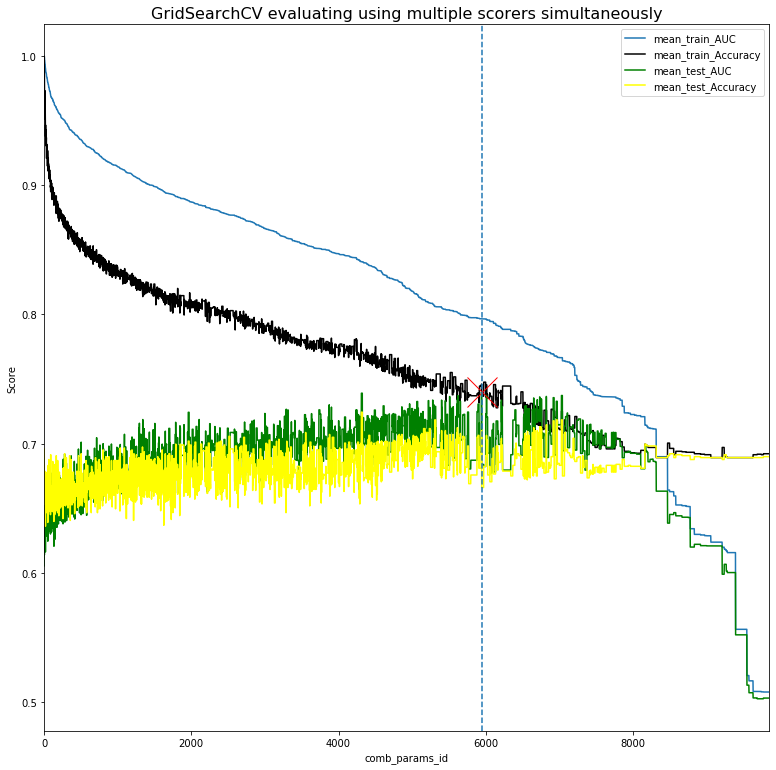

In [593]:
import matplotlib.pyplot as plt
import pandas as pd

## make Id columns 

sort_selected_df['comb_params_id'] = index_string

# gca stands for 'get current axis'
plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
          fontsize=16)

plt.xlabel("Comb_params_id")
plt.ylabel("Score")



ax = plt.gca()

sort_selected_df.plot(kind='line',x='comb_params_id',y='mean_train_AUC',ax=ax)
sort_selected_df.plot(kind='line',x='comb_params_id',y='mean_train_Accuracy', color='black', ax=ax)
sort_selected_df.plot(kind='line',x='comb_params_id',y='mean_test_AUC',color='green', ax=ax)
sort_selected_df.plot(kind='line',x='comb_params_id',y='mean_test_Accuracy', color='yellow', ax=ax)


best_index_sort= sort_selected_df[sort_selected_df['old_comb_params_id'] == '3429'].index

plt.plot(best_index_sort, best_score, 'rx',markersize=30)

plt.axvline(x= best_index_sort, ls = '--')

# Annotate the best score for that scorer
#ax.annotate("%0.2f" % best_score, (best_index, best_score + 0.005))

plt.show()

/Users/ethannicholas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,index,params,mean_train_AUC,mean_test_AUC,mean_train_Accuracy,mean_test_Accuracy,old_comb_params_id


In [361]:
### variables corelation mapping pca  

import matplotlib.pyplot

from matplotlib.pyplot import quiver

var_comb_df = result_df[['param_max_features', 'param_min_samples_leaf', 'param_min_samples_split', 'mean_test_AUC']]


## changeing the catgegorical data
var_comb_df['param_max_features'] = pd.Categorical(var_comb_df['param_max_features'])

var_comb_df['param_max_features_discret'] = var_comb_df['param_max_features'].cat.codes


new_df = var_comb_df[['param_max_features_discret', 'param_min_samples_leaf', 'param_min_samples_split', 'mean_test_AUC']]


import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA as sklearnPCA


std_scale_new_df = preprocessing.StandardScaler().fit(new_df)

df_std = std_scale_new_df.transform(new_df)

#sklearn_pca = sklearnPCA(n_components=2)   #we want just the first two PCs
#pca_data = sklearn_pca.fit_transform(new_df)   #we want just the first two PCs


#PCs = pca_data.components_
df_std

pd_df_std = pd.DataFrame(df_std, columns= ['max_features', 'min_samples_leaf' , 'min_samples_split' , 'mean_test_AUC'])

export_csv = new_df.to_csv (r'pca.csv', index = None, header=True)

/Users/ethannicholas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/ethannicholas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [70]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))


The scikit-learn version is 0.21.2.


In [366]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA, KernelPCA
from sklearn.datasets import make_circles

kpca = KernelPCA(kernel="rbf", fit_inverse_transform=True, gamma=10)


df_kpca = kpca.fit_transform(df_std)

df_kpca 

plt.figure()
plt.scatter(df_kpca[], c="red",
            s=20, edgecolor='k')

plt.title("Projection by KPCA")
plt.xlabel(r"1st principal component in space induced by $\phi$")
plt.ylabel("2nd component")

plt.tight_layout()
plt.show()



TypeError: scatter() missing 1 required positional argument: 'y'

<Figure size 432x288 with 0 Axes>

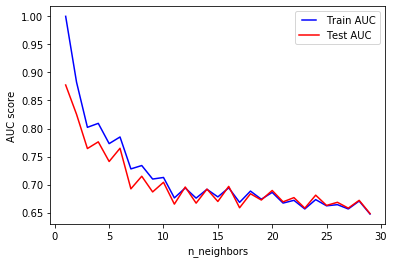

In [24]:
neighbors = list(range(1,30))

train_results = []
test_results = []
for n in neighbors:
    model = KNeighborsClassifier(n_neighbors=n)
    model.fit(xTrain_df_std,yTrain)
    train_pred = model.predict(xTrain_df_std)
    
    false_positive_rate, true_positive_rate, thresholds = roc_curve(yTrain, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(xTest_df_std)
    
    alse_positive_rate, true_positive_rate, thresholds = roc_curve(yTest, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(neighbors, train_results, 'b', label="Train AUC")
line2, = plt.plot(neighbors, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_neighbors')
plt.show()

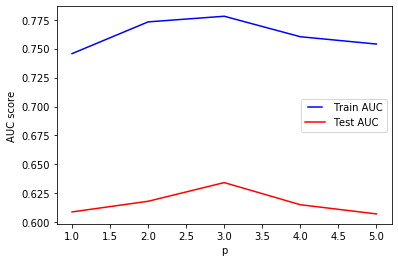

In [26]:
distances = [1, 2, 3, 4, 5]
train_results = []
test_results = []
for p in distances:
    model = KNeighborsClassifier(p=p)
    model.fit(xTrain_df_std, yTrain)
    train_pred = model.predict(xTrain_df_std)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(yTrain, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(xTest_df_std)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(yTest, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(distances, train_results, 'b', label="Train AUC")
line2, = plt.plot(distances, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('p')
plt.show()

### 

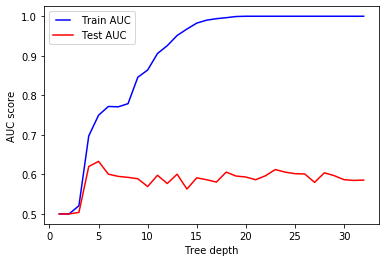

In [28]:
###max_depth

max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth)
    dt.fit(xTrain_df_std, yTrain)
    train_pred = dt.predict(xTrain_df_std)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(yTrain, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous train results
    train_results.append(roc_auc)
    y_pred = dt.predict(xTest_df_std)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(yTest, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous test results
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

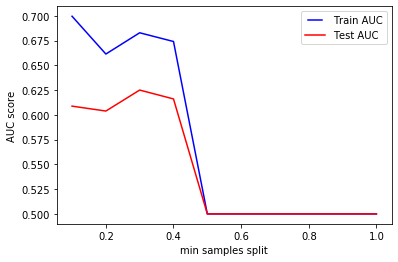

In [38]:
#min_samples_split

min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
    dt = DecisionTreeClassifier(min_samples_split=min_samples_split)
    dt.fit(xTrain_df_std, yTrain)
    train_pred = dt.predict(xTrain_df_std)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(yTrain, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(xTest_df_std)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(yTest, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

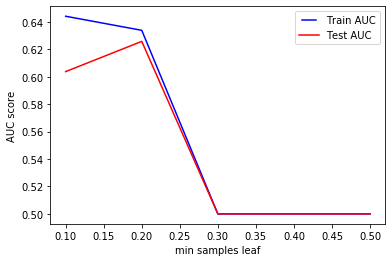

In [41]:
#min_samples_leaf

min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
    dt.fit(xTrain_df_std, yTrain)
    train_pred = dt.predict(xTrain_df_std)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(yTrain, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(xTest_df_std)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(yTest, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_leafs, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

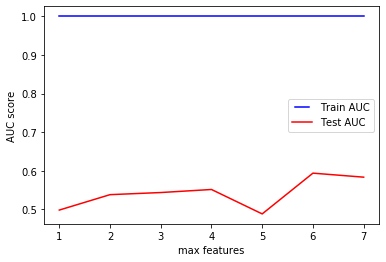

In [46]:
#max_features

max_features = list(range(1,xTrain.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
   dt = DecisionTreeClassifier(max_features=max_feature)
   dt.fit(xTrain_df_std, yTrain)
   train_pred = dt.predict(xTrain_df_std)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(yTrain, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = dt.predict(xTest)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(yTest, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_features, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.show()


### Comparision of 3 classifiers: 
### knn5 and knn10 -- both of them having accruacy score around 0.6795 amd 0.6693 with mean centering and staderlised.  bit lower accuracy scores -with 0.63 and 0.65  were generated in Decision Tree .  the observation was knn5 showed  a slitly  higher accuracy score compare comparing with other two classifers. the overall perfomance are not satisfying which indicating the feature engineering is needed for better performance.

## Feature Engineering

In [706]:
df1['erl'].value_counts()

0.500000    1430
1.000000      14
3.500849       1
Name: erl, dtype: int64

In [707]:
df1['pox'].value_counts()

0.00    1469
0.83      11
0.50       4
Name: pox, dtype: int64

## feature engineering
### The confilict of feature engineering is scaling first then featrue interaction or the other way around. 
### this seems to be a context  to context, and features to features bases' decision. Without knowing the features background information   in yeast data, early decision is hard to make. It turns out need to be result oritented appoach.
### the approach will be chosen are performing features interaction firstly and than scalling after spliting the datasets into training and testing data.
### Before the features generation, there is something need to be pointed out which are the columns 'erl' and 'pox' are ambiguous.
### the decisons were keeping the 'erl' column but drop the 'pox' before apply the feature generation and standarlisation.
### the reason for these decison, is erl has majority 0.5 values and less 1 in the data which may less problematic in features interacting. 
### but the 'pox' coaints majorty 'zero' which is not helpful in the fearue generating. but later on will be join back
### into the final data for features selection.




### =========================================

### feature generation method one by pair-wised interaction 

### feature interaction before scalling 

In [555]:
features =  x.loc[:, x.columns != 'pox']

## deal with zero values in the data cause the infinite and NaN values in feature interaction
## there are 2 '0' values in column 'mit' , 1 '0' values in colun 'vac' and 'nuc'
## imputing them by median, since there are really rare appear.

features = features.replace({'mit': 0},features['mit'].median() )
features = features.replace({'vac': 0}, features['vac'].median() )
features = features.replace({'nuc': 0}, features['nuc'].median() )

features_gen = features.rename(columns={  'mcg': 'f1', 
                                            'gvh': 'f2', 
                                            'alm' : 'f3',
                                            'mit' : 'f4', 
                                            'vac' : 'f5', 
                                            'erl' : 'f6',
                                            'nuc' : 'f7'})

    
for i in range(1, len(features.columns)):
    for j in range(1, len(features.columns)):  
        #multiplication 
        #features_gen['f1*f2'] = features_gen['f1'] * features_gen['f2']
        features_gen['f' + str(i) + '*'+ 'f' + str(j) ] = features_gen['f' + str(i) ] * features_gen['f' + str(j)]

        #addition
        features_gen['f' + str(i) + '+'+ 'f' + str(j) ] = features_gen['f' + str(i) ] + features_gen['f' + str(j)]

        # Division and substraction by value itselves are not usefull for new features.
        if(i != j): 
            #division
            features_gen['f' + str(i) + '/'+ 'f' + str(j) ] = features_gen['f' + str(i) ] / features_gen['f' + str(j)]

            
            #substraction
            features_gen['f' + str(i) + '-'+ 'f' + str(j) ] = features_gen['f' + str(i) ] - features_gen['f' + str(j)]

In [556]:
from sklearn.feature_selection import mutual_info_classif

# stadardlised the data

std_scale_new_features= preprocessing.StandardScaler().fit(features_gen)
new_features_std = std_scale_new_features.transform(features_gen)

le = preprocessing.LabelEncoder()
le.fit(df_labels)


y = le.transform(df_labels) 

### apply Mutual information to sorting the features 
mi = mutual_info_classif(new_features_std,y)

top_feature = []

full_features = sorted(zip(mi, features_gen.columns), reverse = True)

for score,feature in full_features:
        top_feature.append(feature)
        

In [622]:
## feature selection on featrure interaction ---Method 1 

### Scaleling is better taken afer spliting the data.

#spliting data and standardlised data 

# get column names from 30 top features to compare with the accuracy in knn 5 model

for i in range(1,31): 
    col_inx = 31 - i
    
    column_name = top_feature[0: col_inx]
    
    df_x = features_gen[column_name]

    le = preprocessing.LabelEncoder()
    le.fit(df_labels)

    y = le.transform(df_labels) 

    print('Number of Top features selected by MI:',df_x.shape[1])
 
    x_Train, x_Test, y_Train, y_Test = train_test_split(df_x, y, test_size = 0.33, random_state = 100)



    # standalisation transformation ---with Train and test data separately 
    std_scale_x_Train = preprocessing.StandardScaler().fit(x_Train)
    std_scale_x_Test = preprocessing.StandardScaler().fit(x_Test)
    x_Train_df_std = std_scale_x_Train.transform(x_Train)
    x_Test_df_std = std_scale_x_Test.transform(x_Test)



    #knn(k=5)  with median imputed mean stadalisased data


    print('------------standalised transformation---------------------')

    knn10 = KNeighborsClassifier(n_neighbors=10)
    knn10.fit(x_Train_df_std,y_Train)
    pred_knn10 = knn10.predict(x_Test_df_std)

    print('Before the parameter tuning accuracy :', accuracy_score(y_Test,pred_knn5))

####  best parameter tuning fitting 

    print('----------------best parameter tuning vs------------------')
          
    knn_90 = KNeighborsClassifier(n_neighbors=10, algorithm= 'auto', leaf_size=1, n_jobs= -1, p=1,weights= 'distance')
    knn_90.fit(x_Train_df_std,y_Train)
    pred_90 = knn_90.predict(x_Test_df_std)

    print('After Hyperparameter Tuning accuracy :', accuracy_score(y_Test,pred_90))
    
    

Number of Top features selected by MI: 30
------------standalised transformation---------------------
Before the parameter tuning accuracy : 0.6285714285714286
----------------best parameter tuning vs------------------
After Hyperparameter Tuning accuracy : 0.7040816326530612
Number of Top features selected by MI: 29
------------standalised transformation---------------------
Before the parameter tuning accuracy : 0.6285714285714286
----------------best parameter tuning vs------------------
After Hyperparameter Tuning accuracy : 0.7122448979591837
Number of Top features selected by MI: 28
------------standalised transformation---------------------
Before the parameter tuning accuracy : 0.6285714285714286
----------------best parameter tuning vs------------------
After Hyperparameter Tuning accuracy : 0.7
Number of Top features selected by MI: 27
------------standalised transformation---------------------
Before the parameter tuning accuracy : 0.6285714285714286
----------------best par

## Method 1 ---Number of features 

###  Top 24 or 27 features in top mutual information gain gave best result, but not too significant compare with orginal data with knn5 model

### Top 8 features gave accuracy score 0.6836
### Top 24 features gave accuracy score 0.6878
### Top 27 features gave accuracy score 0.6878

### ========================================================
## Method 2 ---K Mean Clustering labels 

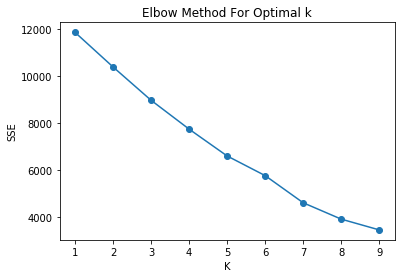

In [604]:
from sklearn.cluster import KMeans
### method 2-- kmean clustering label


### standardlisation transformation

features_std_scale = preprocessing.StandardScaler().fit(df_features_selected)

features_std = features_std_scale.transform(df_features_selected)

###PCA 
from sklearn.decomposition import PCA as sklearnPCA


pca_std = sklearnPCA()
pca_feature_std = pca_std.fit_transform(features_std)


sse = []

K = range(1,10)

for k in K:
    kmean_m = KMeans(n_clusters=k) 
    kmean_m = kmean_m.fit(pca_feature_std)
    sse.append(kmean_m.inertia_)

plt.plot(K, sse, '-o')
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('Elbow Method For Optimal k')
plt.show()



In [605]:
# k = 5 is the elbow point 

# generates label for new features

kmean_5 = KMeans(n_clusters=5)
kmean_5 = kmean_5.fit(pca_feature_std)
f_lables = kmean_5.predict(pca_feature_std)




In [624]:
## adding new f_cluster labels in to the dataset
features['f_cluster'] = f_lables

le = preprocessing.LabelEncoder()
le.fit(df_labels)

y = le.transform(df_labels) 

generated_x = df_features_selected 

#selected_x
 
x_train, x_test, y_train, y_test = train_test_split(generated_x, y, test_size = 0.33, random_state = 100)



# standalisation transformation ---with Train and test data separately 
std_scale_x_train = preprocessing.StandardScaler().fit(x_train)
std_scale_x_test = preprocessing.StandardScaler().fit(x_test)
x_train_df_std = std_scale_x_train.transform(x_train)
x_test_df_std = std_scale_x_test.transform(x_test)


####deep copy try 

#knn(k=5)

knn5_cl = KNeighborsClassifier(n_neighbors=5)
knn5_cl.fit(x_train_df_std,y_train)
pred_knn5_cl = knn5_cl.predict(x_test_df_std)

print(accuracy_score(y_test,pred_knn5_cl))

#knn( optimal parameters)
knn_90_cl = KNeighborsClassifier(n_neighbors=10, algorithm= 'auto', leaf_size=1, n_jobs= -1, p=1,weights= 'distance')
knn_90_cl.fit(x_train_df_std,y_train)
pred_90_cl = knn_90_cl.predict(x_test_df_std)

print(accuracy_score(y_test,pred_90_cl))


0.6959183673469388
0.7



### ----------------------------------------------------------------

### Q. Which parameter values you selected and why. 

### In feature selection+generation the parameter I choose is trying out for geting top 0 to 30  features from Mutual information Gain list. Since 30 features were generated from 8 featrues are quite big number. the concern is number of features goes up will bring overfitting situation.  however the result from the knn5 accuracy score are gaving top 8 and top 24 ,27 are behave quite similar,  which indicates that under 30 may still in the relative safe zone. 



### -----------------------------------------------------------------------------------------------------------------------------

### Q Whether feature selection+generation with interaction term paris can deliver anaccuracy boost, based on your evidence from part 1. 

###  A. part 1 with original datasets and standarlised data  knn5 and knn10 obtained accruacy score around 0.6795 amd 0.6693. 
 
### after Mutual information and features interaction we got the result of training with the  knn5-standalised data
### Top 8 features gave accuracy score 0.6836
### Top 24 features gave accuracy score 0.6878
### Top 27 features gave accuracy score 0.6878

### This only demonstrate a litting improvement from the approach.  Maybe could try other Feature selection method and feature engineering method like recursive elimination and SVM and etc. 


### ----------------------------------------------------------------------------------------------------------------------------

### Q. Whether feature generation with clustering labels can deliver an accuracy boost,based on your evidence from part 2. 

### part 1 with original datasets and standarlised data  knn5 and knn10 obtained accruacy score around 0.6795 amd 0.6693. 

### In part 2, after obtaining Kmean Clustering label to train the knn5 obtained a 0.7040 in accuracy score. which shows 0.2% increase with one extra feature. 

### -----------------------------------------------------------------------------------------------------------------------------